# Recurrent Neural Neworks

Until now, we have focused mostly on fixed length data. Tabular or image format, e.g. all images in fashion mnist are 28x28 images. However, many tasks require dealing with sequential data, image captioning, speech synthesis, music generation etc. 

Recurrent Neural Networks (RNNs) capture the dynamics of sequeces via _recurrent_ connections, which can roughly be thought of as cycles in the network nodes. These cycles are unrolled across timestseps, so that the order of operations is unambiguous. The same underlying parameters are applied at each time step, the standard connections are applied sychronously to propagate each layer's activations to the next layer at the same time step. However, the recurrent connections are dynamic, passing information across adjacent timesteps. 

While the inputs of many tasks requiring RNNs cannot be represented as fixed-length inputs, the data can often be represented as a series of inputs with fixed length (e.g. a video is a series of still images, text as a series of fixed length blocks). 

Research in this area has often been driven by natural language processing, so this section will focus on examples from text data. We'll begin by covering some of the basic notation for dealing with sequences, then some evaluation metrics for assessing the performance of sequentially structured data. After that, we'll cove r basic concepts of language modelling an duse this to build a first RNN. 

# Working with Sequences

The major change of perspective in working with sequences is that our data is now an ordered list of feature vectors $\mathrm{x_1, x_2 .. x_T}$, where each feature vector $x_t$ is indexed by a timestep $t \in \mathbb{Z}^{+}$. 

Some timesteps might consist of extremely long single sequences, e.g. in sensor readings, where we might produce teaining and test sets by randomly subsampling subsequences of some particular length. More often, our data comes as a collection of sequences. E.g. a collection of documents with its own sequence of words, and its own length $T_i$. Or sequences representing patient stays in a hospital, where each stay consists of a number of events. 

In previous examples, we assumed that each sample was chosen independently from the parent distribution. Here, while we might still assume that each individual _set_ of sequences is independent, we cannot assume that each sample is independent of the others. E.g. words early in a document have a high probability of being correlate dwith words occurring later in a document. This is... probably unsurprising, otherwise why would we chose to represent this data as a sequence?

Mostly, we just expext that the sequences themselves are sampled from some underlying distribution across all sequences. This allows for sequences to appear significantly different at the beginning vs at the end. 

Sometimes, we wish to predict a fixed target y given sequentially sturctured input (e.g. sentiment analysis of a movie review), at other times, we may wish to predict a sequence from  a fixed input (e.g. image captioning). Sometimes, we may have sequences on both ends, e.g. video captioning or machine translation. Sequence to sequence tasks can be iether (i) aligned, where the input at each step aligns with the output (e.g. speech tagging) or (ii) unaligned, where they don't necessarily exhibit a step for step correspondance(e.g. machine translation). 

The most straightforward target to handle of any kind if unsupervised density modelling (also called sequence modeling). Here, given a collection of sequences, we estimate the probability mass function that tells us justhow likely we are to see any particular sequence.

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

## Autoregressive Models

Let's consider the FTSE100 index, at each time step $t \in \mathbb{Z}^{+}$, we observe the price $x_t$ of the index. 

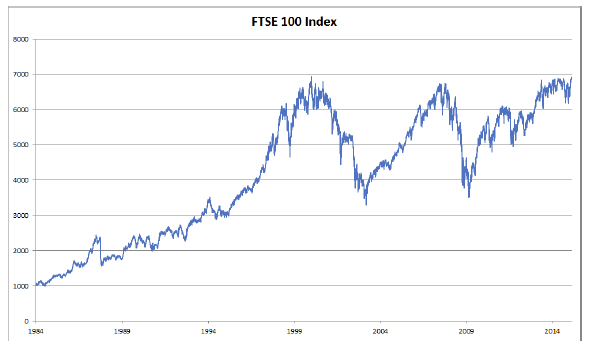

^ prices in the FTSE100 index. 

Lets say we'd like to predict tomorrow's stock prices, absent any other features (e.g. news, financial reporting, etc), the available signal is the history of the prices up to the current date. Thus, we're only interested in knowing the probability distribution of the current price given the previous prices

$$P(x_t | x_{t-1}, ... x_{1})$$

While estimating the entire distirbution might be tricky, for making a trade we only really care about estimating the expected value at some time t, along with the variance. One way to do this might be to apply a linear regression model - models that regress the value of a signal based on the previous values of that _same_ signal are called _autoregressive models_. However, the number of inputs varies depending on the t! That is to say, the number of inputs increases with the amount od ata that we encounter. 

There are a few common strategies of managing this. One is a sort of temporal locality, we might recognise that it's not always necessary to go back to the beginning of time to predict the next value, maybe only more recent data are required. Perhaps we only look back along some window $\tau$, so that we only have $x_{t-1}, x_{t-2}, ..., x_{t-\tau}$ observations. This is attractive as it keeps the number of inputs the same, so we can use any linear neural network we've already used for training. 

We often assume that the dynamics that underpin how a value x changes over time are constant. 

## Sequence Models

Sometimes, we're interested in computing the joint probability of an entire sequence. This commonly occurs when the sequence is comprised of individual _tokens_ i.e, words in the case of natural language processing. Language modelling gives us the ability to evaluate which of a number of sequences is the most likely. It also allows us to _sample_ sequences, including determining the most likely. We can treat lagauge modelling as an autoregressive problem. 

### Markov Models

Whenever we condition our prediction such that we throw away history beyond the previous $\tau$ timesteps, we have a Markov model (or say that the sequence satisfies the Markov condition). When $\tau = 1$, i.e. we only care about the previous timestep, we say that the data can be fit by a _first order Markov model_ - generalised to kth order Markov model for $\tau = k$. It's often useful to assume that a Markov condition is satisfied, even if we know this is only approximately true in most cases. Even massive RNN and Transformer based language models assume that the data can be fit with a Markov model of k- on the order of a few thousands.  

## Training

Let's experiment withs omeon continuous valued synthetic data

In [10]:
class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
        self.save_hyperparameters()
        self.time = torch.arange(1, T + 1, dtype=torch.float32)
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2

    def get_dataloader(self, train): 
        features = [self.x[i: self.T - self.tau + i] for i in range(self.tau)]
        self.features = torch.stack(features, 1)
        self.labels = self.x[self.tau:].reshape((-1, 1))
        i = slice(0, self.num_train) if train else slice(self.num_train,  None)
        return self.get_tensorloader([self.features, self.labels], train, i)

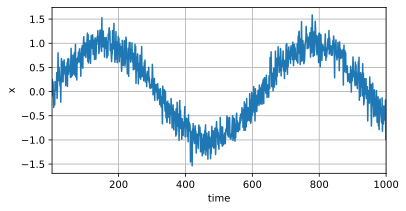

In [11]:
data = Data()
d2l.plot(data.time, data.x, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

### Model assuming the data fits a markov condition

Lets assume the model fits a $\tau$th order Markov condition, so that we can predict x_t with the past tau observations. 

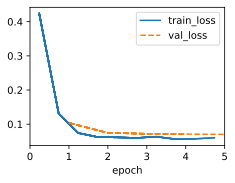

In [12]:
model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

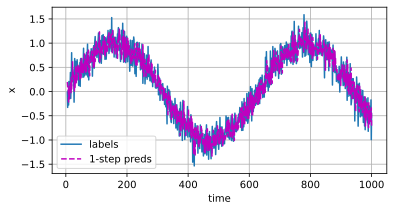

In [13]:
# jkust predicting one step into the furue
onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x', legend=['labels', '1-step preds'], figsize=(6, 3))

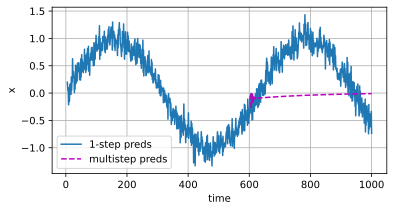

In [16]:
# predicting many steps into the future based on just the most recent timestep, pretty catastrophic.3
# But then, we're trying to make a k=400 step ahead prediction, so maybe it's unsurprising that this is atrocious.

multistep_preds = torch.zeros(data.T)
multistep_preds[:] = data.x
for i in range(data.num_train + data.tau, data.T):
    multistep_preds[i] = model(
        multistep_preds[i - data.tau:i].reshape((1, -1))
    )
multistep_preds = multistep_preds.detach().numpy()


d2l.plot(
    [data.time[data.tau:], data.time[data.num_train+data.tau:]],
    [onestep_preds, multistep_preds[data.num_train+data.tau:]], 'time',
    'x', legend=['1-step preds', 'multistep preds'], figsize=(6, 3)
)

In [20]:
# Lets examine this more closely, making k-step ahead predictions for a few different values

def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i : i+data.T-data.tau-k+1])
        
    for i in range(k):
        preds = model(torch.stack(features[i : i+data.tau], 1))
        features.append(preds.reshape(-1))
        
    return features[data.tau:]

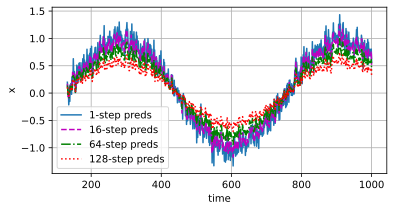

In [22]:
steps = (1, 16, 64, 128)
preds = k_step_pred(steps[-1])
d2l.plot(data.time[data.tau+steps[-1]-1:],
[preds[k - 1].detach().numpy() for k in steps], 'time', 'x',
legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))